# sedproxy vignette examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
import os

# Add the path to your sedproxy directory
sys.path.insert(0, '/Users/tanaya/USC/sedproxy')

# Import directly
from clim_to_proxy_clim import clim_to_proxy_clim

from plot_pfms import plot_pfms
from bioturbation_weights import bioturbation_weights
from proxy_conversion import proxy_conversion

In [3]:
N41_t21k_climate_df = pd.read_csv('./data/N41_t21k_climate.csv')


In [4]:
N41_t21k_climate_df

,1,2,3,4,5,6,7,8,9,10,11,12
0,297.856750,297.387848,298.060211,299.224487,299.676086,300.216705,300.548340,299.918243,299.640045,299.638641,299.930145,299.338135
1,297.988586,297.534149,297.826263,299.008301,299.715118,299.674255,300.160858,300.668549,299.781891,299.849670,299.782349,298.969879
2,297.842682,297.746643,298.359863,299.145874,299.605621,300.091339,300.150024,300.142303,299.542664,299.598511,299.810516,298.917236
3,297.696075,297.665863,298.492065,299.513672,300.019958,299.897125,300.443237,299.980255,299.697266,300.064819,299.736328,298.990692
4,297.769073,297.343628,297.945160,299.174103,299.993988,299.824371,300.144409,300.397797,299.949646,300.160980,299.815002,298.963501
...,...,...,...,...,...,...,...,...,...,...,...,...
22035,300.398376,300.016052,300.339905,301.255066,302.072510,302.331451,302.629669,303.113129,303.415253,302.645966,302.094177,301.097687
22036,300.493683,300.159546,300.706055,301.621887,301.892212,302.567261,303.199188,303.063538,302.977295,302.493683,302.467407,301.545135
22037,300.827179,300.371948,300.632568,301.689270,302.252899,302.446503,302.751526,303.307953,303.143921,302.994904,302.401093,301.192169
22038,300.169983,300.050964,300.660126,301.637085,302.315247,302.356537,302.730042,303.244904,302.580048,302.639038,302.660583,301.425751


In [5]:
clim_in = N41_t21k_climate_df - 273.15
rows = clim_in.shape[0]
time = np.arange(-39, -39+rows)
clim_in.index = time

In [6]:
clim_in = N41_t21k_climate_df.iloc[::-1] - 273.15
clim_in.index = np.arange(0, clim_in.shape[0])  # or leave index as-is if you're using BP directly

In [7]:
np.shape(clim_in)

(22040, 12)

In [8]:
req_timepoints = np.arange(1,20000,100) # time points for which we want to model a proxy value 

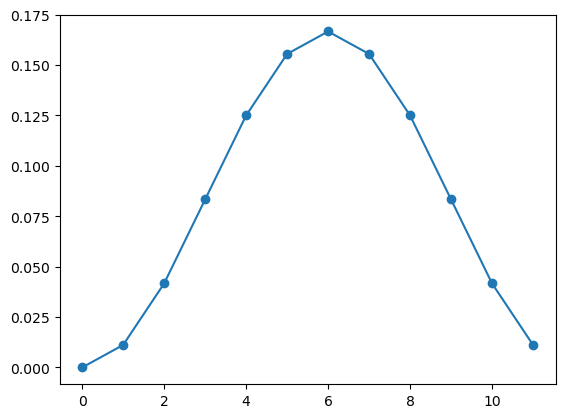

In [9]:
hab_weights = 1 + np.cos(np.linspace(np.pi, 3*np.pi-2*np.pi/12,12))
hab_weights = hab_weights/np.sum(hab_weights)

plt.plot(hab_weights, marker='o')

In [10]:
# Load stages key
stages_key_df = pd.read_csv("./data/stages_key.csv")

# Normalize columns and stage names
stages_key_df.columns = [c.replace(".", "_") for c in stages_key_df.columns]
stages_key_df["stage"] = stages_key_df["stage"].str.replace(".", "_", regex=False)



## Running the proxy forward model

In [13]:
# running the proxy forward model

PFM = clim_to_proxy_clim(clim_signal=clim_in,
                         timepoints=req_timepoints,
                         habitat_weights=hab_weights,
                         calibration_type= 'Uk37',
                         sed_acc_rate=50,
                         sigma_meas=0.25,
                         sigma_ind=1,
                         plot_sig_res=1,
                         n_samples = 30,
                         stages_key=stages_key_df)

Mapping result:


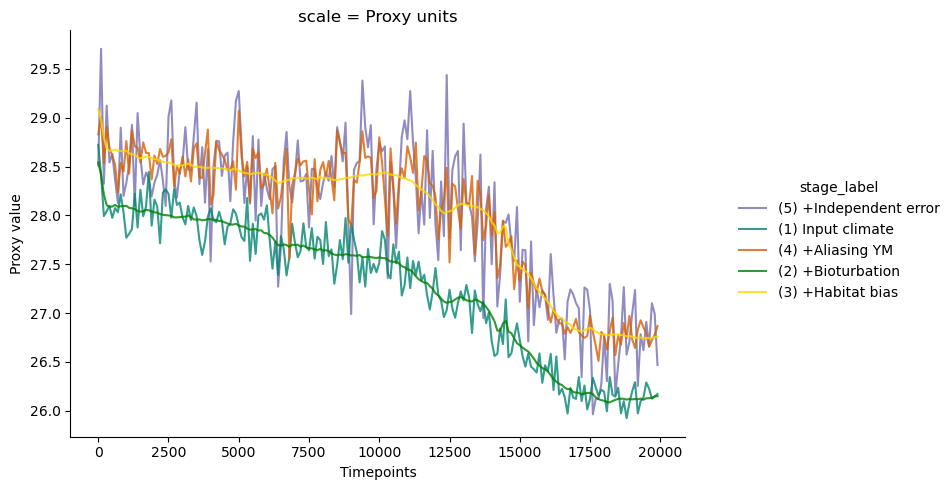

In [14]:
plot_pfms(PFM, stages_key=stages_key_df)

### Running the forward model with n_replicates > 1

In [13]:
PFM_5_reps = clim_to_proxy_clim(clim_signal=clim_in,
                         timepoints=req_timepoints,
                         habitat_weights=hab_weights,
                         sed_acc_rate=50,
                         sigma_meas=0.25,
                         sigma_ind=1,
                         plot_sig_res=1,
                         n_samples = 30,
                         n_replicates= 5,
                         stages_key=stages_key_df)

Mapping result:
  proxy_bt_sb_sampYM -> (4) +Aliasing YM
  simulated_proxy -> (5) +Independent error
  proxy_bt -> (2) +Bioturbation
  proxy_bt_sb -> (3) +Habitat bias
  clim_signal_ann -> (1) Input climate


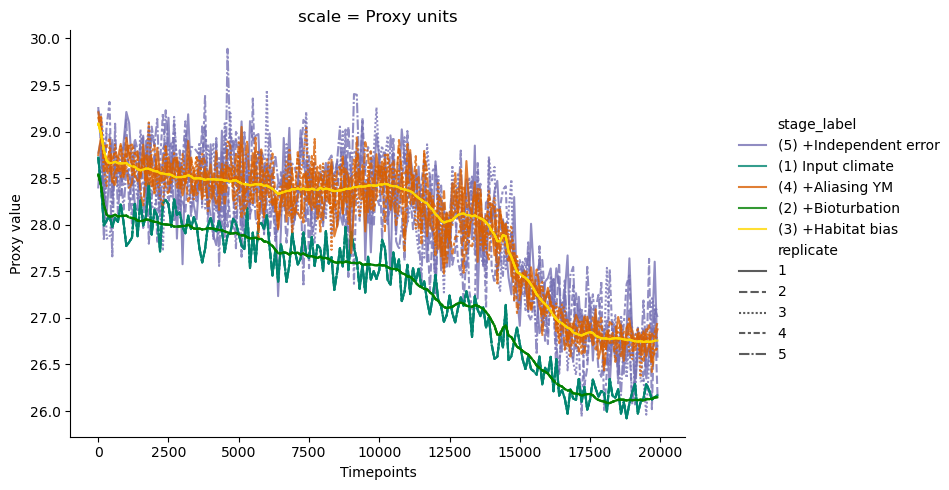

In [15]:
plot_pfms(PFM_5_reps, stages_key=stages_key_df)

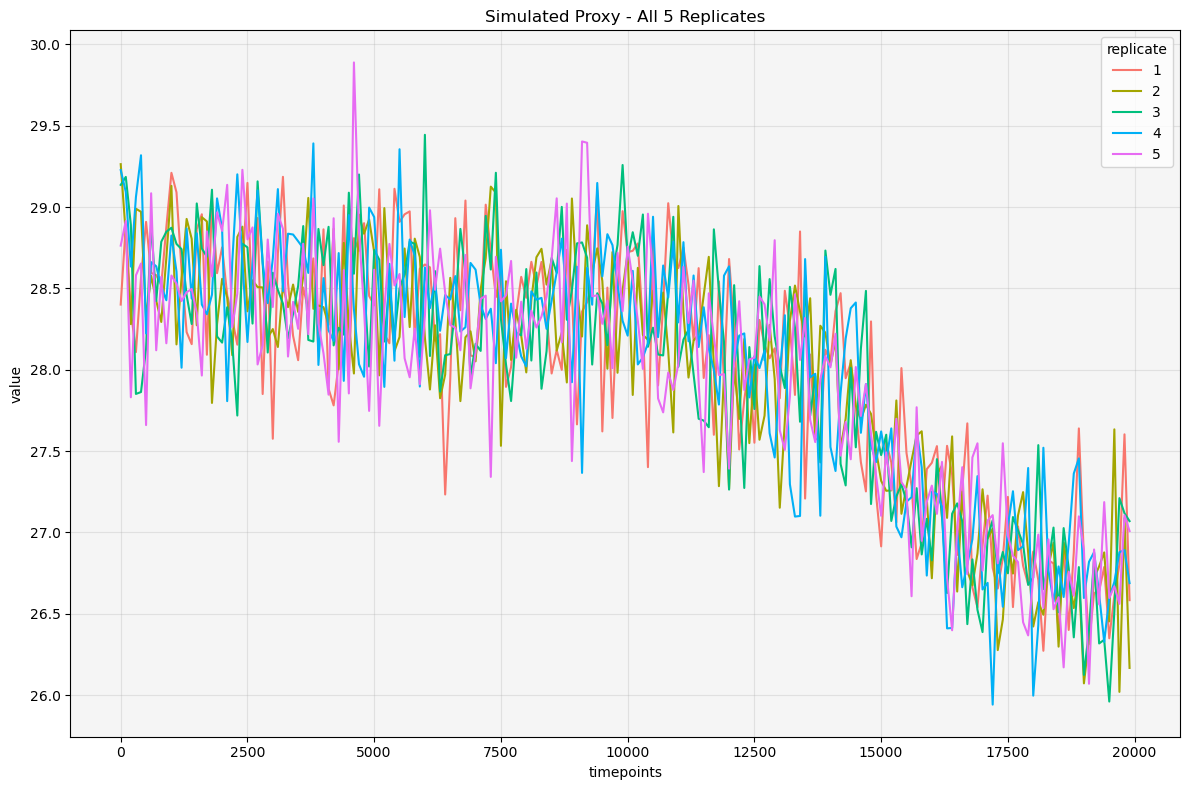

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

r_colors = ['#F8766D', '#A3A500', '#00BF7D', '#00B0F6', '#E76BF3']

filtered_data_all5 = (PFM_5_reps['everything']
                      .query("stage == 'simulated_proxy'"))

plt.figure(figsize=(12, 8))
sns.lineplot(data=filtered_data_all5, 
             x='timepoints', 
             y='value', 
             hue='replicate',
             palette=r_colors,  # All 5 R colors
             linewidth=1.5)

plt.title('Simulated Proxy - All 5 Replicates')
plt.xlabel('timepoints')
plt.ylabel('value')
plt.grid(True, alpha=0.3)
plt.gca().set_facecolor('#F5F5F5')
plt.tight_layout()
plt.show()


## Influence of sample sizes

In [19]:
pfm_30 = clim_to_proxy_clim(
    clim_signal=clim_in,
    timepoints=req_timepoints,
    # calibration_type="MgCa",  # commented out like in R
    sed_acc_rate=50,
    habitat_weights=hab_weights,  # assuming this is your hab_wts variable
    sigma_meas=0.26, 
    sigma_ind=2,
    n_samples=30,
    n_replicates=300,
    stages_key=stages_key_df
)

pfm_5 = clim_to_proxy_clim(
    clim_signal=clim_in,
    timepoints=req_timepoints,
    # calibration_type="MgCa",  # commented out like in R
    sed_acc_rate=50,
    habitat_weights=hab_weights,  # assuming this is your hab_wts variable
    sigma_meas=0.26, 
    sigma_ind=2,
    n_samples=5,
    n_replicates=300,
    stages_key=stages_key_df
)

In [21]:
import numpy as np

# Here we take a shortcut. Instead of actually simulating the measurement of 6 samples 
# at each timepoint we just shrink sigma_meas by sqrt(6) and multiply the number of forams by 6.
pfm_5x6 = clim_to_proxy_clim(
    clim_signal=clim_in,
    timepoints=req_timepoints,
    # calibration_type="MgCa",  # commented out like in R
    sed_acc_rate=50,
    habitat_weights=hab_weights,
    sigma_meas=0.26 / np.sqrt(6),  # Reduced measurement error
    sigma_ind=2,
    n_samples=6*5,  # 30 total samples (6 measurements × 5 forams each)
    n_replicates=300,
    stages_key=stages_key_df
)

pfm_120 = clim_to_proxy_clim(
    clim_signal=clim_in,
    timepoints=req_timepoints,
    # calibration_type="MgCa",  # commented out like in R
    sed_acc_rate=50,
    habitat_weights=hab_weights,
    sigma_meas=0.26,  # Standard measurement error
    sigma_ind=2,
    n_samples=120,  # 120 individual forams
    n_replicates=300,
    stages_key=stages_key_df
)

pfm_10x12 = clim_to_proxy_clim(
    clim_signal=clim_in,
    timepoints=req_timepoints,
    # calibration_type="MgCa",  # commented out like in R
    sed_acc_rate=50,
    habitat_weights=hab_weights,
    sigma_meas=0.26 / np.sqrt(10),  # Reduced measurement error
    sigma_ind=2,
    n_samples=10*12,  # 120 total samples (10 measurements × 12 forams each)
    n_replicates=300,
    stages_key=stages_key_df
)

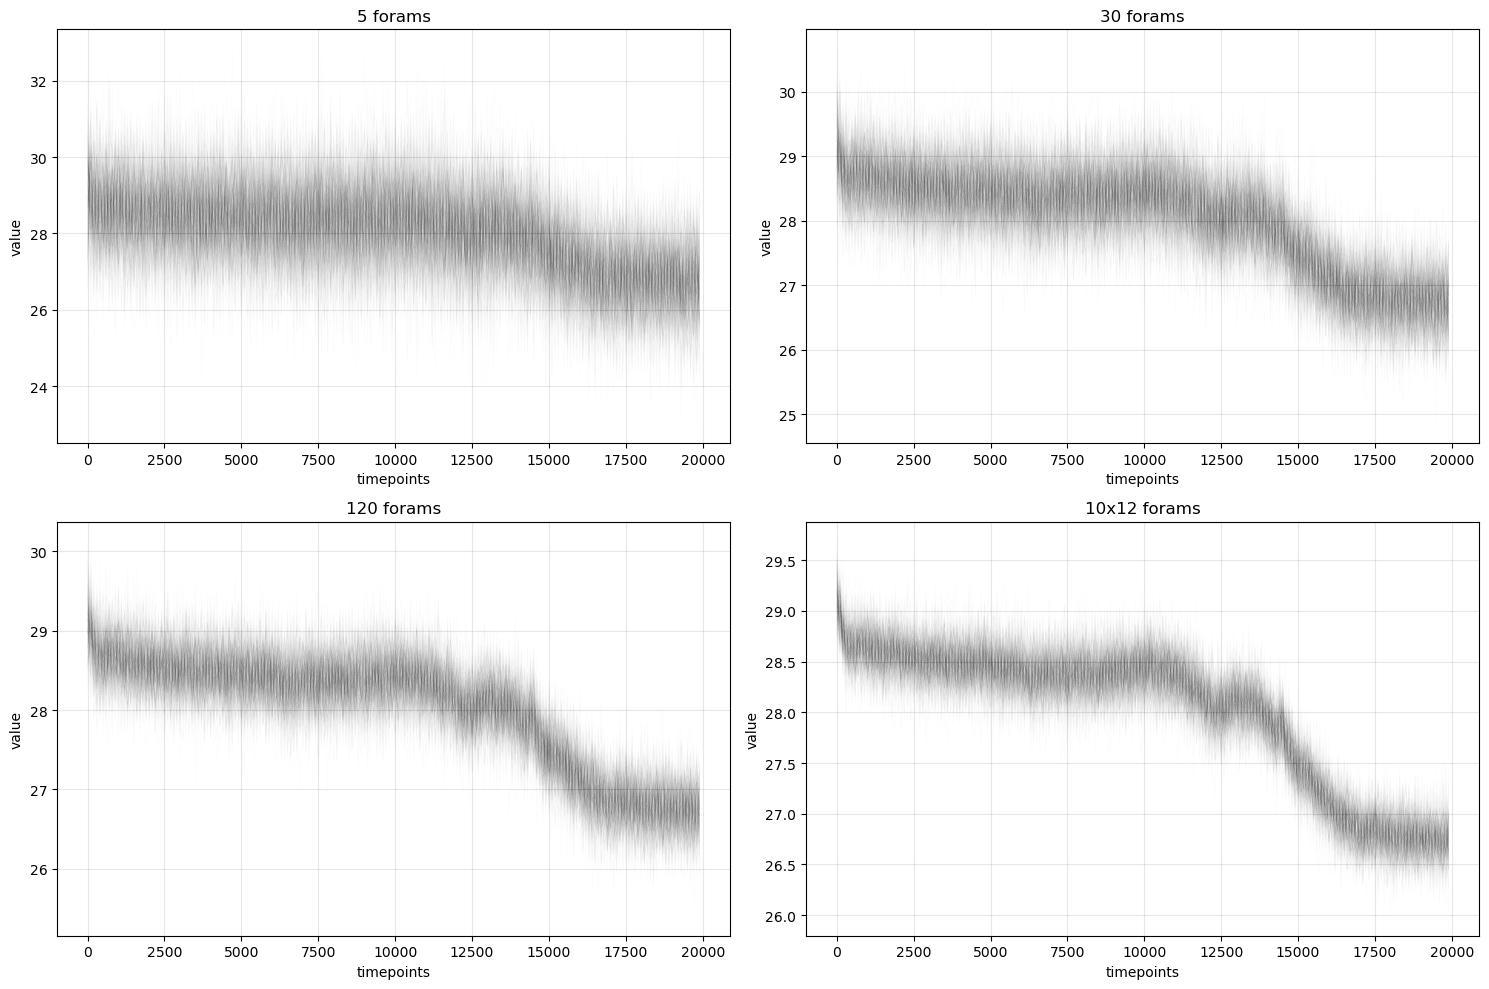

In [22]:
# Combine the PFM results (equivalent to bind_rows with .id)
combined_pfms = pd.concat([
    pfm_5['everything'].assign(measurement_strategy='5 forams'),
    pfm_30['everything'].assign(measurement_strategy='30 forams'),
    # pfm_5x6['everything'].assign(measurement_strategy='6*5 forams'),  # commented out like in R
    pfm_120['everything'].assign(measurement_strategy='120 forams'),
    pfm_10x12['everything'].assign(measurement_strategy='10x12 forams')
], ignore_index=True)

# Create ordered categorical for measurement strategy (equivalent to factor with levels)
strategy_order = ['5 forams', '30 forams', '120 forams', '10x12 forams']
combined_pfms['measurement_strategy'] = pd.Categorical(
    combined_pfms['measurement_strategy'], 
    categories=strategy_order, 
    ordered=True
)

# Filter and plot (equivalent to filter + ggplot + geom_line + facet_wrap)
filtered_data = combined_pfms[combined_pfms['stage'] == 'simulated_proxy']

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, strategy in enumerate(strategy_order):
    strategy_data = filtered_data[filtered_data['measurement_strategy'] == strategy]
    
    # Plot each replicate with low alpha (equivalent to geom_line(alpha = 0.01))
    for replicate in strategy_data['replicate'].unique():
        rep_data = strategy_data[strategy_data['replicate'] == replicate]
        axes[i].plot(rep_data['timepoints'], rep_data['value'], 
                    alpha=0.01, color='black', linewidth=0.5)
    
    axes[i].set_title(strategy)
    axes[i].set_xlabel('timepoints')
    axes[i].set_ylabel('value')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Error summary

/var/folders/8z/yk22dpg55ml5c3_lq1hb1pn40000gn/T/ipykernel_76799/2134226217.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['stage', 'timepoints', 'measurement_strategy'])


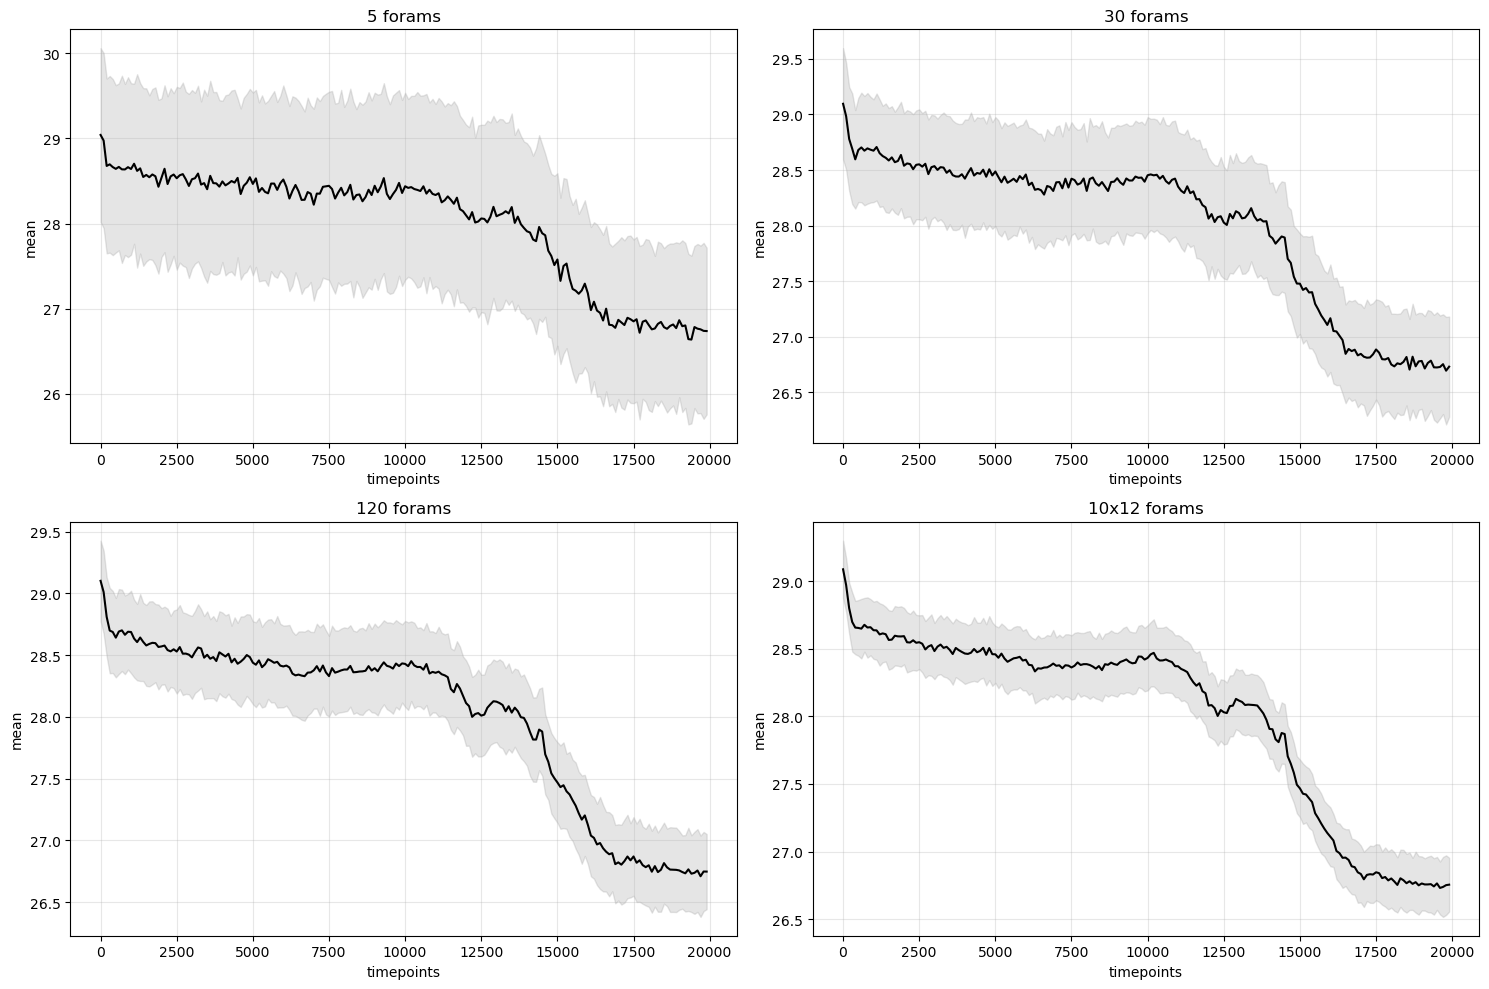

<Figure size 1500x1000 with 0 Axes>

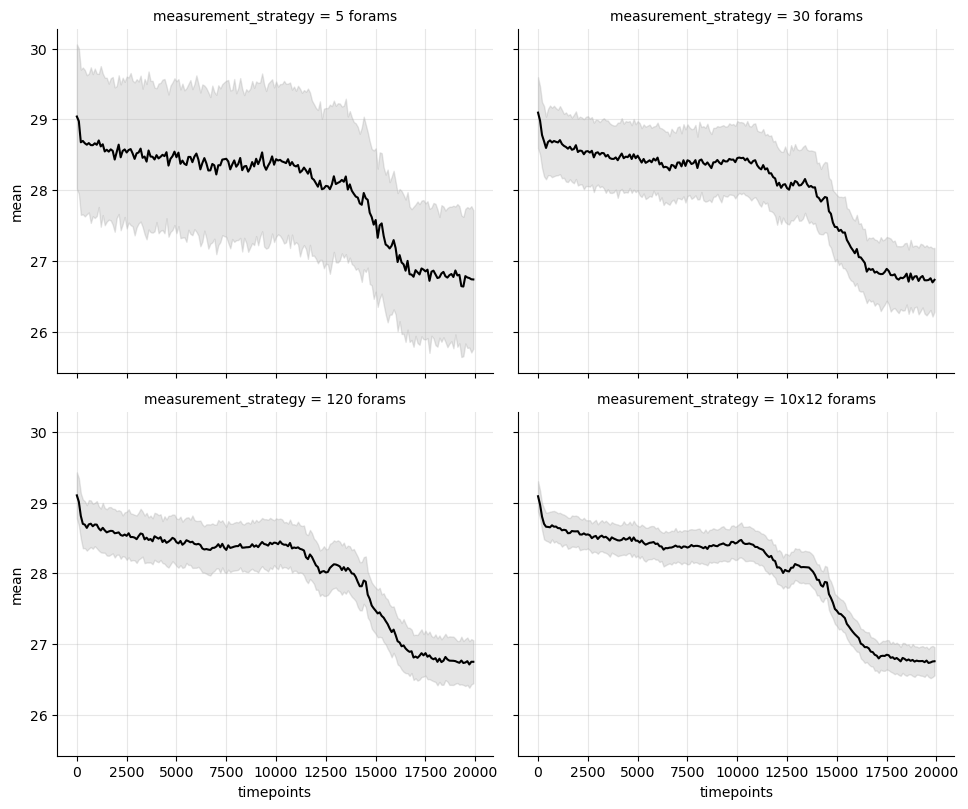

Mean Error by Measurement Strategy:
          stage measurement_strategy  mean_error
simulated_proxy             5 forams      1.0439
simulated_proxy            30 forams      0.4870
simulated_proxy           120 forams      0.3335
simulated_proxy         10x12 forams      0.2219

Formatted Table:
stage                 simulated_proxy
measurement_strategy                 
5 forams                       1.0439
30 forams                      0.4870
120 forams                     0.3335
10x12 forams                   0.2219

Publication-style Table:
Measurement Strategy Mean Error  
-----------------------------------
5 forams             1.0439      
30 forams            0.4870      
120 forams           0.3335      
10x12 forams         0.2219      


/var/folders/8z/yk22dpg55ml5c3_lq1hb1pn40000gn/T/ipykernel_76799/2134226217.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['stage', 'measurement_strategy'])


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Summarise the error
# We can take the mean and standard deviation across replicates for each timepoint and plot this instead.

# Calculate mean and standard deviation across replicates (equivalent to group_by + summarise)
mean_error = (combined_pfms
              .groupby(['stage', 'timepoints', 'measurement_strategy'])
              .agg({'value': ['mean', 'std']})
              .reset_index())

# Flatten column names
mean_error.columns = ['stage', 'timepoints', 'measurement_strategy', 'mean', 'sd']

# Filter for simulated_proxy stage and plot
filtered_error = mean_error[mean_error['stage'] == 'simulated_proxy']

# Create faceted plot with mean line and standard deviation ribbon
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, strategy in enumerate(strategy_order):
    strategy_data = filtered_error[filtered_error['measurement_strategy'] == strategy]
    
    # Plot mean line
    axes[i].plot(strategy_data['timepoints'], strategy_data['mean'], 
                color='black', linewidth=1.5)
    
    # Add standard deviation ribbon (equivalent to geom_ribbon)
    axes[i].fill_between(strategy_data['timepoints'], 
                        strategy_data['mean'] - strategy_data['sd'],
                        strategy_data['mean'] + strategy_data['sd'],
                        alpha=0.2, color='gray')
    
    axes[i].set_title(strategy)
    axes[i].set_xlabel('timepoints')
    axes[i].set_ylabel('mean')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_facecolor('white')  # equivalent to theme_bw()

plt.tight_layout()
plt.show()

# Alternative using seaborn (more ggplot-like)
plt.figure(figsize=(15, 10))

g = sns.FacetGrid(filtered_error, col='measurement_strategy', col_wrap=2, 
                  height=4, aspect=1.2, col_order=strategy_order)

def plot_mean_ribbon(data, **kwargs):
    plt.plot(data['timepoints'], data['mean'], color='black', linewidth=1.5)
    plt.fill_between(data['timepoints'], 
                    data['mean'] - data['sd'],
                    data['mean'] + data['sd'],
                    alpha=0.2, color='gray')

g.map_dataframe(plot_mean_ribbon)
g.set_axis_labels('timepoints', 'mean')

# Make it look like theme_bw()
for ax in g.axes.flatten():
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('white')

plt.show()

## Summarize the error for each measurement strategy
# Calculate mean error across all timepoints for each strategy
error_summary = (filtered_error
                 .groupby(['stage', 'measurement_strategy'])
                 .agg({'sd': 'mean'})
                 .reset_index()
                 .rename(columns={'sd': 'mean_error'}))

# Display as a nice table (equivalent to knitr::kable())
print("Mean Error by Measurement Strategy:")
print("=" * 50)
print(error_summary.to_string(index=False, float_format='%.4f'))

# Or as a formatted pandas table
print("\nFormatted Table:")
display_table = error_summary.pivot(index='measurement_strategy', 
                                   columns='stage', 
                                   values='mean_error')
print(display_table.round(4))

# If you want it to look more like a publication table:
print("\nPublication-style Table:")
print(f"{'Measurement Strategy':<20} {'Mean Error':<12}")
print("-" * 35)
for _, row in error_summary.iterrows():
    print(f"{row['measurement_strategy']:<20} {row['mean_error']:<12.4f}")

# Optional: Save the summary as a CSV
# error_summary.to_csv('measurement_strategy_errors.csv', index=False)